In [1]:
%matplotlib inline

import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
pd.options.mode.chained_assignment = None #default = 'warn'

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

In [2]:
columns = [
    'mpg', 
    'cylinders', 
    'displacement', 
    'horsepower',
    'weight', 
    'acceleration', 
    'model year',
    'origin', 
    'car name'
]

data = pd.read_csv(auto_mpg_data, sep='\s+', header=None, names=columns)

data_no_missing = data[data['horsepower'] != '?']
data_no_missing['horsepower'] = data_no_missing['horsepower'].astype('float64')
data = data.replace('?', '93.5')
data['horsepower'] = data['horsepower'].astype('float64')

In [3]:
def freeman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    if h < 1:
        return 1
    return int( h)

In [4]:
def histogram_w_whiskers(data, variable_name, zoom=None):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
        
    # start the plot: 2 rows, because we want the boxplot on the first row
    # and the hist on the second
    fig, ax = plt.subplots(
        2, figsize=(7, 5), sharex=True,
        gridspec_kw={"height_ratios": (.7, .3)}  # the boxplot gets 30% of the vertical space
    )

    # the histogram
    ax[0].hist(data[variable_name],bins=bins, color="dimgray", weights=empirical_weights)
    ax[0].set_title(f"{variable_name} distribution - Freeman Diaconis")
    ax[0].set_ylabel("Relative Frequency")
    if zoom:
        ax[0].set_ylim((0, zoom))
    # the box plot
    ax[1].boxplot(data[variable_name], vert=False)
    # removing borders
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xlabel(variable_name)

    # and we are good to go
    plt.show()
    plt.close()
    return h

In [5]:
def histogram_trio(data, variable_name, zoom=1.0):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

    fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    fewer_bins = int(len(bins) * .50)
    more_bins = int(len(bins) * 2)

    n, bins, patches = ax[1].hist(data[variable_name], color="DimGray", bins=bins, weights=empirical_weights) # <---
    ax[1].set_xlabel(variable_name)
    ax[1].set_ylabel("Relative Frequency")
    ax[1].set_title(f"Relative Frequency Histogram of {variable_name}")
    ax[1].set_ylim((0, zoom))
    
    n, bins, patches = ax[0].hist(data[variable_name], color="DimGray", bins=fewer_bins, weights=empirical_weights)
    ax[0].set_xlabel(variable_name)
    ax[0].set_ylabel("Relative Frequency")
    ax[0].set_title(f"Relative Frequency Histogram of {variable_name} (Fewer Bins)")
    
    n, bins, patches = ax[2].hist(data[variable_name], color="DimGray", bins=more_bins, weights=empirical_weights)
    ax[2].set_xlabel(variable_name)
    ax[2].set_ylabel("Relative Frequency")
    ax[2].set_title(f"Relative Frequency Histogram of {variable_name} (More Bins)")

    plt.show()
    plt.close()

### $MPG \ vs \ Cylinders$

Since $mpg$ is our target variable, I will focus the discussion of pairwise analysis on $mpg$ with our other variables. Let's first look at $cylinders$. As theorized, as $cylinders$ increases from 4 to 6 to 8, I'd expect the fuel consumption to increase, and thus the $mpg$ of the car to decrease.

Since these are both numeric variables, we can look at both the Pearson and Spearman correlation coefficient to get an idea of how linearly related the variables are, and the monotonicity of the relationship, respectively.

In [6]:
print('r = ', stats.pearsonr(data['cylinders'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['cylinders'], data['mpg'])[0])

r =  -0.7753962854205543
rho =  -0.8218644914450967


We do in fact see strong negative correlations here, as predicted. Pearson's r is -0.78, so as number of $cylinders$ increases, we would expect $mpg$ to linearly decrease as a result. Spearman's rho is a -0.82 so we expect a strong monotonic decreasing relationship.

Let's look at a scatter plot to get a visual idea of this relationship.

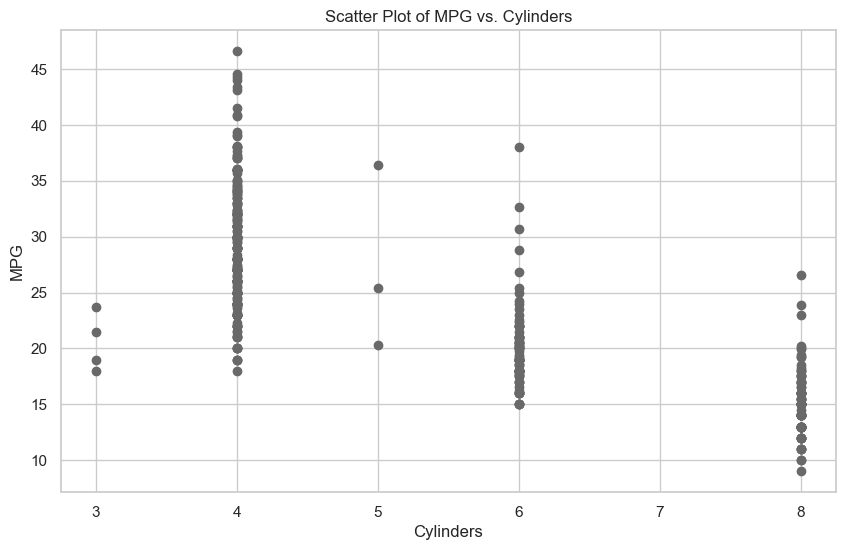

In [7]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['cylinders'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Cylinders')
axes.set_title("Scatter Plot of MPG vs. Cylinders")

plt.show()
plt.close()

Hmm not the best plot. Because we only have a few discrete values for $cylinders$, I will go back and treat it again as an ordered categorical variable. In this case, it would be more interesting to look at multiple boxplots. Note I am using some functions from the `eda.py` file.

In [8]:
import eda

C:\Users\Jhirs\AppData\Local\Temp\ipykernel_22940\953294986.py:5: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels = pd.unique(sorted(data['cylinders'].values))


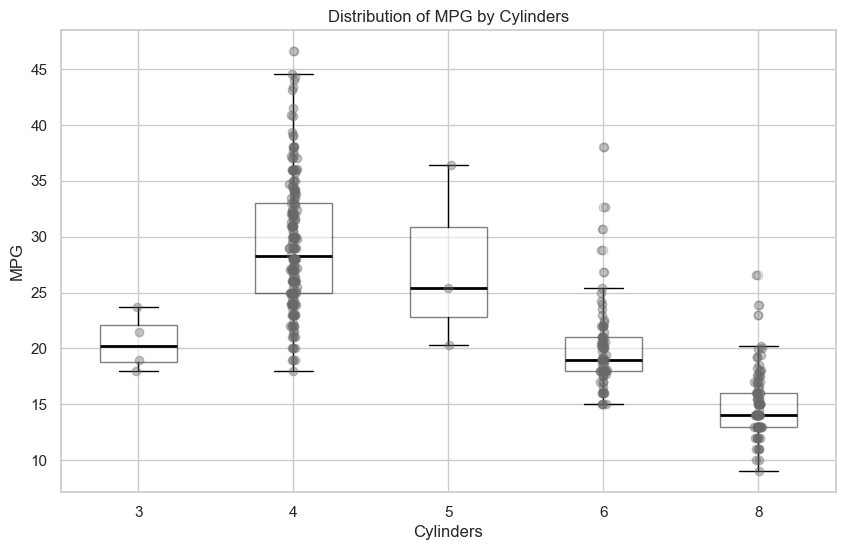

In [9]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

labels = pd.unique(sorted(data['cylinders'].values))
grouped = data.groupby('cylinders')
grouped_data = [grouped['mpg'].get_group(k) for k in labels]
patch = axes.boxplot(grouped_data, labels=labels, patch_artist=True, zorder=1)
eda.restyle_boxplot(patch)

for i,k in enumerate(labels):
    subdata = grouped['mpg'].get_group(k)
    x = np.random.normal(i+1, 0.01, size=len(subdata))
    axes.plot(x, subdata, 'o', alpha=0.4, color='dimgray', zorder=2)

axes.set_ylabel('MPG')
axes.set_xlabel('Cylinders')
axes.set_title('Distribution of MPG by Cylinders')

plt.show()
plt.close()

So we see $mpg$ go up a bit as we increase from 3 to 4 cylinder cars. We decrease $mpg$ slightly at 5 cylinders, and then much more sharply at 6 and then 8 cylinder cars. We notice the 6 cylinder and 8 cylinder boxplots also have smaller interquartile ranges and relatively more extreme values then those cars with 4 cylinders.

There's a bit of an overlap between 3 and 6 cylinders, as well as the distributions for 4 and 5 cylinders.

### $MPG \ vs \ Displacement$

Now let's look at how $displacement$ might affect $mpg$. Again, $displacement$ is often representative of engine size, and the equation we saw from our single variable EDA showed that it relies on number of cylinders. As such, we could predict that $displacement$ will have the same kind of correlation to $mpg$ that we saw for $cylinders$ and $mpg$ - strongly negatively correlated. Let's look at the correlation coefficients.

In [10]:
print('r = ', stats.pearsonr(data['displacement'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['displacement'], data['mpg'])[0])

r =  -0.804202824805898
rho =  -0.8556920118178749


It looks like our predictions are spot on. Again we have a strong negative Pearson's r of -0.80, and a strong negative Spearman's rho of -0.86. Not too surprising since we know $displacment$ and $cylinders$ are directly related.

Since $displacement$ is a continuous numeric variable, I think a scatter plot here would be best to visualize this relationship.

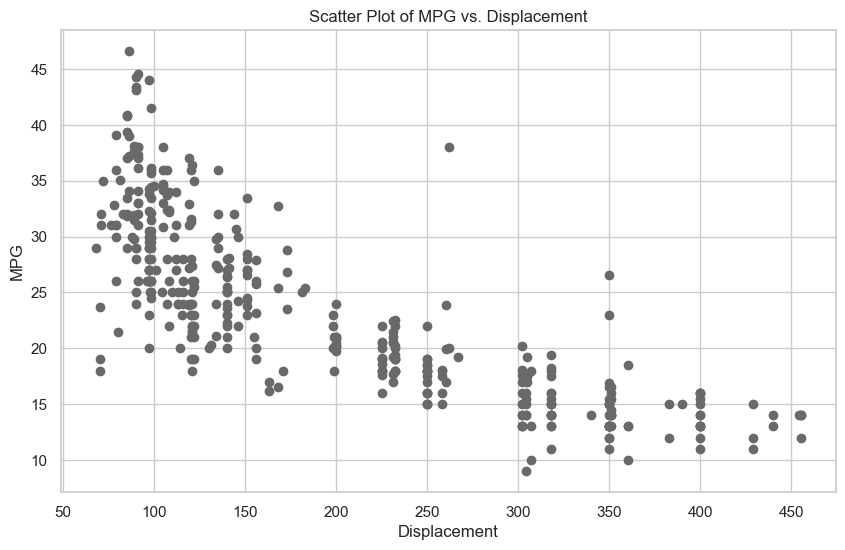

In [11]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['displacement'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Displacement')
axes.set_title("Scatter Plot of MPG vs. Displacement")

plt.show()
plt.close()

We do in fact see a linear decreasing relationship between $mpg$ and $displacement$ - not perfect mind you, but good enough for our purposes. There seems to be one extreme value at a $displacement$ of about 260, where the $mpg$ is much higher, around 38 or so. There are also a few higher values for $mpg$ when $displacement$ is around 350. 

### $MPG \ vs \ Horsepower$

Now let's take a look at how $horsepower$ might affect $mpg$. We already know $horsepower$ is a continuous numeric variable, so I predict we will see similar results as $displacement$ - more $horsepower$ leads to lower $mpg$. Let's see the correlation coefficients.

In [12]:
print('r = ', stats.pearsonr(data['horsepower'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['horsepower'], data['mpg'])[0])

r =  -0.7734532045742155
rho =  -0.8479748547388403


Again we see a strong negative correlation between these two variables, with a Pearson's r of -0.77 and Spearman's rho of -0.85. This is what we'd expect, since we already saw higher number of $cylinders$ leads to lower $mpg$, and typically higher $cylinders$ also corresponds to higher $horsepower$. Let's look at a scatter plot.

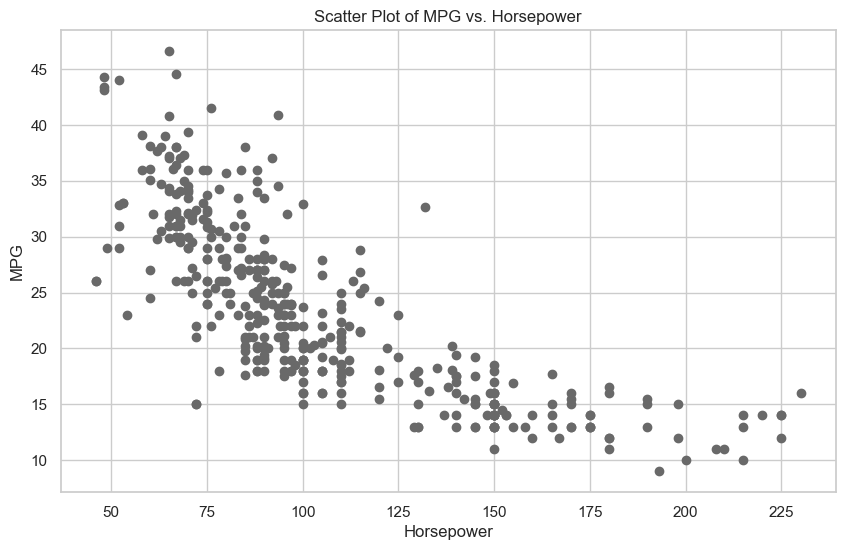

In [13]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['horsepower'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Horsepower')
axes.set_title("Scatter Plot of MPG vs. Horsepower")

plt.show()
plt.close()

A very similar scatter plot to what we saw with $mpg$ and $displacement$. We could imagine how a regression line could be fit here, but that's getting ahead of ourselves, and we shouldn't put the cart before the $horsepower$.

1. So far all our features are negatively correlated with $mpg$. Do we have any variables that are positively correlated here?

2. We had a slight spike at 150 $horsepower$ in our single variable EDA. It doesn't look like there are any extreme values related to $mpg$ there, but we might be interested in looking further at the value of 130 $horsepower$ and about 33 $mpg$.

### $MPG \ vs \ Weight$

Let's move on to $mpg$ vs $weight$. Remember that $weight$ is also a continuous numeric variable. There was a steadily decreasing proportion of cars with higher weights as we saw in single variable EDA. I think we'll continue to see the same pattern here when compared to $mpg$ - as we increase $weight$, you'd probably need a larger engine/higher $displacement$, and thus lower $mpg$. Here are the correlation coefficients.

In [14]:
print('r = ', stats.pearsonr(data['weight'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['weight'], data['mpg'])[0])

r =  -0.831740933244335
rho =  -0.8749473981990712


Very strongly negatively correlated, with -0.83 and -0.87 for Pearson's r and Spearman's rho, respectively. I think a scatterplot will show a similar plot to what we saw with $mpg$ and $displacement$ as well. This is the strongest correlation we've seen yet, though not by too much.

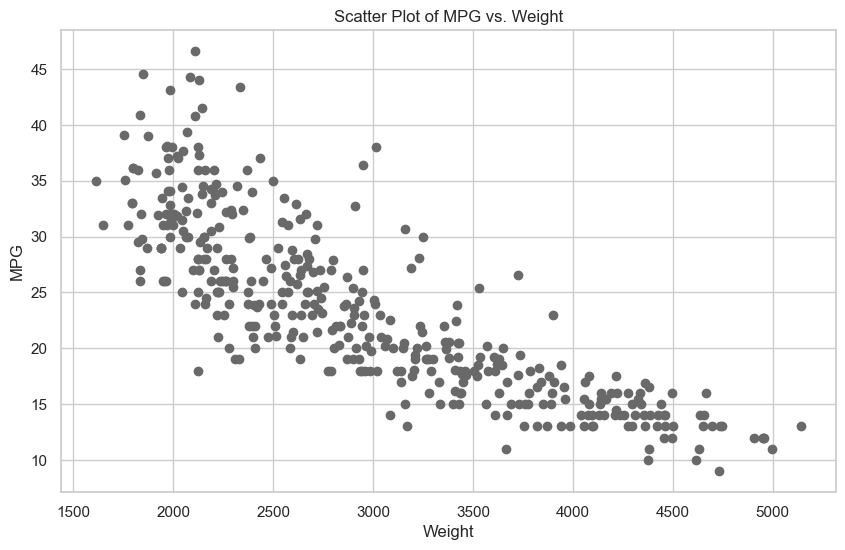

In [15]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['weight'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Weight')
axes.set_title("Scatter Plot of MPG vs. Weight")

plt.show()
plt.close()

Steadily decreasing, no surprise there. We see some more variability at the lower weights than we do for the higher weights. We saw from single variable EDA that weights around 2000 were the most frequent, and weights below 2000 dropped off a bit. The highest $mpg$ cars have weights close to 2100-2200.

### $MPG \ vs \ Acceleration$

Now we can look at how $acceleration$ relates to $mpg$. In general, accelerating a car uses more fuel, so I predict higher values of $acceleration$ will lead to lower $mpg$, although I don't think it will be as strongly correlated as say $mpg$ and $weight$.

In [16]:
print('r = ', stats.pearsonr(data['acceleration'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['acceleration'], data['mpg'])[0])

r =  0.42028891210165065
rho =  0.4386774795708622


We actually see a weak positive correlation here, with Pearson's r of 0.42 and Spearman's rho of 0.44. According to the [EPA](https://www.fueleconomy.gov/feg/factors.shtml#:~:text=Aggressive%20driving%20(speeding%2C%20rapid%20acceleration,more%20idling%20will%20lower%20MPG)), aggressive acceleration and deceleration actually decreases gas mileage by a sizeable chunk, around 15-30% at highway speeds. We can take a look at the scatter plot to visualize this relationship as well.

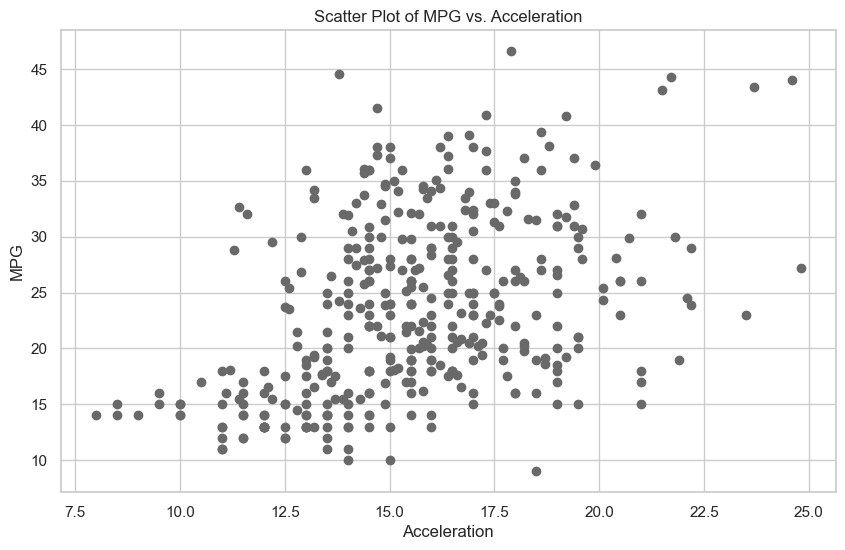

In [17]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['acceleration'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Acceleration')
axes.set_title("Scatter Plot of MPG vs. Acceleration")

plt.show()
plt.close()

We definitely don't see a strong linear relationship here. I mean we are seeing that lower $acceleration$ around 7.5-10.0 typically leads to lower $mpg$ around 15, and vice versa for higher values of $acceleration$, but we have some more extreme values here as well.

1. It's interesting that the highest values of $acceleration$ jump between about 22-27 $mpg$ and then up to 43-44 $mpg$, some of the highest gas mileage.

2. I'd be curious to know exactly how $acceleration$ was measured, did every car use the same road, the same weather conditions, etc.

### $MPG \ vs \ Model \ Year$

Model year is a multi-valued discrete variable with only 13 values between 70-82. Newer cars typically have better gas mileage, as technology has moved foward over the years. I predict we will see cars made more recently will have a higher $mpg$ value, but the correlation will be fairly weak since we don't have a large range of years. We can look at the correlation coefficients first.

In [19]:
print('r = ', stats.pearsonr(data['model year'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['model year'], data['mpg'])[0])

r =  0.5792671330833096
rho =  0.5734687031921751


We do see a fairly strong correlation between $model year$ and $mpg$. Not as strong as some other variables we've looked at, but definitely enough to be interesting. Let's see a scatter plot, though I think we may also need a boxplot, similar to how we looked at $cylinders$ vs $mpg$.

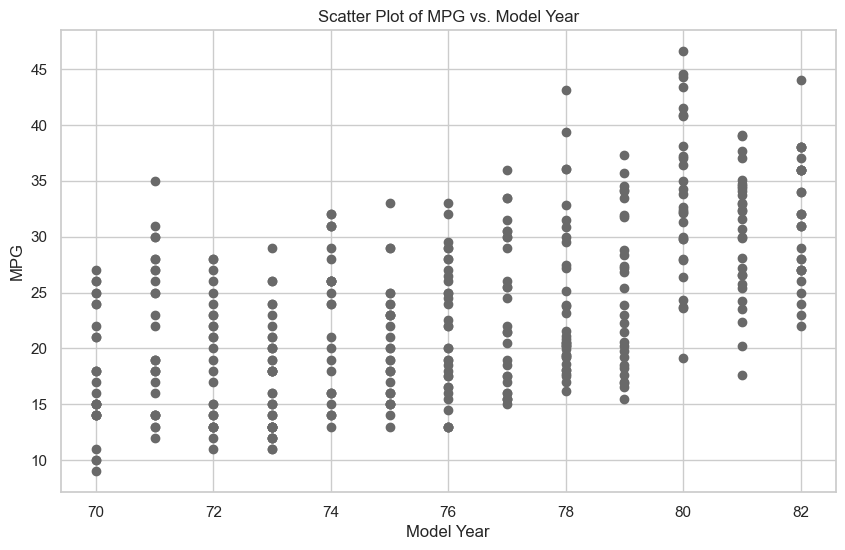

In [20]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(data['model year'], data['mpg'], color='dimgray')

axes.set_ylabel('MPG')
axes.set_xlabel('Model Year')
axes.set_title("Scatter Plot of MPG vs. Model Year")

plt.show()
plt.close()

We do see a pattern here, as the cars closer to $model year$ of 80-82 have higher values of $mpg$ than for cars made between 70-72. I think a boxplot would be more appropriate here, so let's try that as well.

C:\Users\Jhirs\AppData\Local\Temp\ipykernel_22940\105776740.py:5: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels = pd.unique(sorted(data['model year'].values))


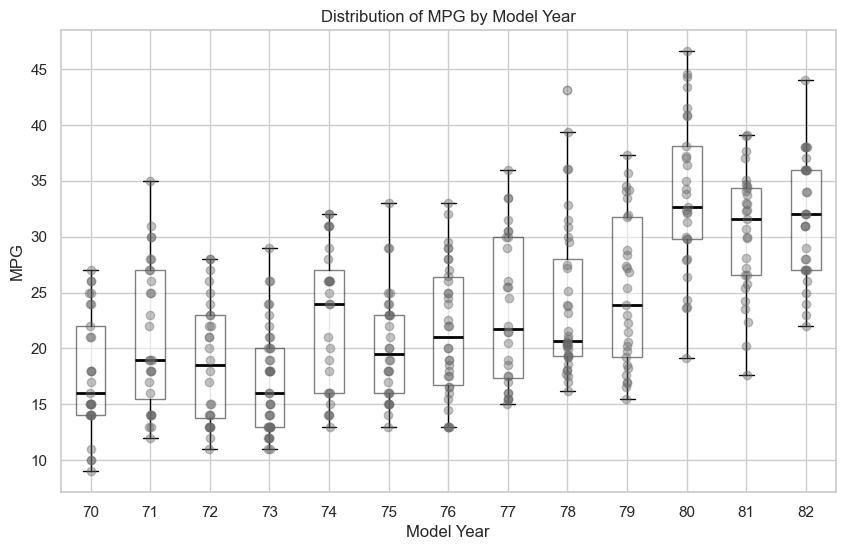

In [21]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

labels = pd.unique(sorted(data['model year'].values))
grouped = data.groupby('model year')
grouped_data = [grouped['mpg'].get_group(k) for k in labels]
patch = axes.boxplot(grouped_data, labels=labels, patch_artist=True, zorder=1)
eda.restyle_boxplot(patch)

for i,k in enumerate(labels):
    subdata = grouped['mpg'].get_group(k)
    x = np.random.normal(i+1, 0.01, size=len(subdata))
    axes.plot(x, subdata, 'o', alpha=0.4, color='dimgray', zorder=2)

axes.set_ylabel('MPG')
axes.set_xlabel('Model Year')
axes.set_title('Distribution of MPG by Model Year')

plt.show()
plt.close()

Not the cleanest plot, but we can see that the median $mpg$ steadily increases from 75 onward. There was a jump at 74, but also a much larger interquartile range, so that may be worth looking at further. The jump from 79 to 80 was fairly large, but then stagnates between 80-82 which is interesting.

1. What happened between 79 and 80 for such a big jump in $mpg$?

2. Why is the median $mpg$ for 74 much higher than in 73 and 75?

These both are interesting questions that could be worth looking into.

### $MPG \ vs \ Origin$

Now let's look at how $origin$ might affect $mpg$. Remember we only have 3 values for $origin$ 1, 2, and 3, which I believe to be America, Europe, and Asia respectively. According to [ResearchGate](https://www.researchgate.net/figure/Comparison-of-Fuel-Economy-Standards-across-Countries_fig1_23723548#:~:text=By%20and%20large%2C%20Japan%20has,European%20Union%20(figure%202)%20), cars made in Japan have the best fuel economy, while America boasts some of the lowest. If that's the case, we should see cars labeled as 1 having lower $mpg$ than cars labeled as 3 or maybe 2 as well. We can start with correlation coefficients.

In [22]:
print('r = ', stats.pearsonr(data['origin'], data['mpg'])[0])
print('rho = ', stats.spearmanr(data['origin'], data['mpg'])[0])

r =  0.5634503597738432
rho =  0.5806936941648105


Similar to $model year$, we see a fairly strong positive correlation with a Pearson's r of 0.56 and Spearman's rho of 0.58. I don't think a scatter plot will be of use since we have only 3 values for $origin$, so instead I will try small multiples so we can get a histogram of $mpg$ by $origin$. I also think densities will be much more interesting to look at than raw counts.

C:\Users\Jhirs\AppData\Local\Temp\ipykernel_22940\3710663492.py:4: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels = pd.unique(sorted(data['origin'].values))


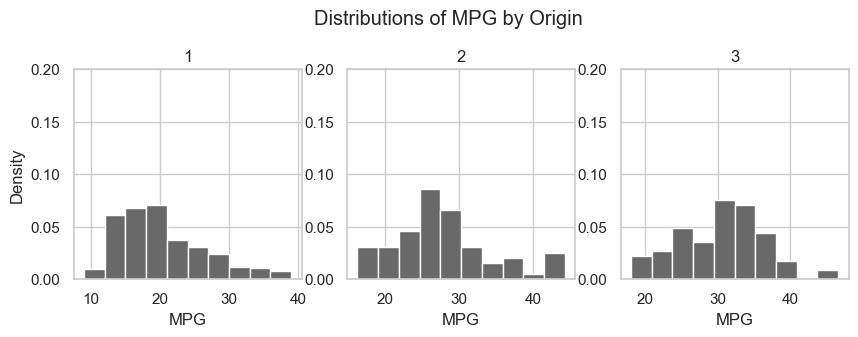

In [27]:
figure = plt.figure(figsize=(10,6))
figure.suptitle('Distributions of MPG by Origin')

labels = pd.unique(sorted(data['origin'].values))
grouped = data.groupby('origin')
grouped_data = [grouped['mpg'].get_group(k) for k in labels]

for i, x in enumerate(labels):
    axes = figure.add_subplot(2,3, i+1)
    subdata = grouped['mpg'].get_group(x).values
    axes.hist(subdata, color='dimgray', density=True)
    axes.set_title(x)
    axes.set_ylim((0,0.2))
    
    axes.set_xlabel('MPG')
    if (i % 3 == 0):
        axes.set_ylabel('Density')

plt.show()
plt.close()

Cars made in country 3 have $mpg$ values centered around 30 mpg, while cars from country 2 are a bit lower around 28 mpg or so. Cars from country 1 have the lowest fuel economy as predicted, centered closer to 20 mpg. We see that cars made in country 3 do on average have higher $mpg$ values than cars from country 1, and slightly better fuel economy than cars from country 2 as well.

1. In each histogram, there's a very small percentage, if any, of cars with $mpg$ around 40, but then an increase for cars with $mpg$ closer to 45. This is an interesting pattern but I'm not sure why this is the case.

### $MPG \ vs \ Car \ Name$

Finally we have $mpg$ against $car \ name$. Remember that we have 305 unique values for $car \ name$ out of our 398 observations in the dataset. Since $car \ name$ is a categorical (string) variable, we can't use our usual correlation coefficients here.

Honestly it would be too difficult to do an EDA analysis for $car \ name$ because there are so many values. There is one thing I can try. It seems that the first word for most car names is the company brand, such as 'ford' or 'toyota'. I can try to group similar values by car company name by taking the first word in each value of $car \ name$ to consolidate some values. Let's try it.

In [37]:
data['brand'] = data['car name'].apply(lambda x: x.split()[0])
print(data['brand'].unique())
print('Unique Car Brands: ', len(data['brand'].unique()))

['chevrolet' 'buick' 'plymouth' 'amc' 'ford' 'pontiac' 'dodge' 'toyota'
 'datsun' 'volkswagen' 'peugeot' 'audi' 'saab' 'bmw' 'chevy' 'hi'
 'mercury' 'opel' 'fiat' 'oldsmobile' 'chrysler' 'mazda' 'volvo' 'renault'
 'toyouta' 'maxda' 'honda' 'subaru' 'chevroelt' 'capri' 'vw'
 'mercedes-benz' 'cadillac' 'mercedes' 'vokswagen' 'triumph' 'nissan']
Unique Car Brands:  37


So now we have 37 values of car brands instead of the 305 for $car \ name$. I believe this is still too many values to really get a good insight to how $car \ name$ and $mpg$ are related. One obvious thing to note is that there are some very clear typos in some of these names - such as 'toyouta' instead of 'toyota', 'chevroelt' instead of 'chevrolet', and 'vokswagen' instead of 'volkswagen'. This is really all I can do for the $car \ name$ variable, but we will press on with the belief that $car \ name$ does not influence $mpg$ to a high degree, at least relative compared to some other variables we've already looked at such as $weight$ and $horsepower$.

### $Summary$